In [201]:
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
import math
from tensorflow import keras

In [308]:
with open("C:\\Users\\Administrator\\source\\data\\dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [309]:
with open("C:\\Users\\Administrator\\source\\data\\dataset0.0.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

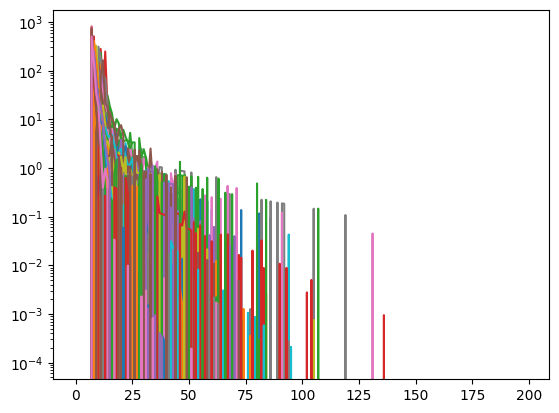

167
[9.169034e-04 7.802959e+01 8.731936e+03 8.500000e-01]


In [310]:
plt.axes(yscale = "log") 
for n in range(NM1):
    plt.plot(sig2[n])
plt.show()
print(NM1)
print(an2[-1])

In [312]:

# def labeling(y,N):
#     ##############
#     a,b = y.shape
#     min0 = np.min(y,0)
#     max0 = np.max(y,0)
#     step = (max0-min0)/N
#     y2 = np.zeros((a,b,N))
    
#     # kernel = np.array([1]) 
#     # kernel = kernel/np.sum(kernel)
    
#     for i in range(a):
#         for j in range(b):
#             if(step[j]!=0):
#                 idx = (y[i,j]-min0[j])/step[j]-1
#                 y2[i,j,int(idx)] = 1
#             else:
#                 y2[i,j,0] = 1
#             # y2[i,j] = np.convolve(y2[i,j],kernel,mode='same')
            
#     return y2    
  

In [313]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
# num_labels = 10
x_train = sig1
y_train = an1
x_test = sig2
y_test = an2

x_train = np.log10((x_train+1e-6)/1000)+11
x_test = np.log10((x_test+1e-6)/1000)+11
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

x_train = np.concatenate((d_train,x_train),axis = 1) 
x_test = np.concatenate((d_test,x_test),axis = 1)
y_train[:,1] = y_train[:,1]/1e2
y_test[:,1] = y_test[:,1]/1e2
y_train[:,2] = y_train[:,2]/200e2
y_test[:,2] = y_test[:,2]/200e2
y_train = y_train[:,1:3]
y_test = y_test[:,1:3]
# y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
# y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 

(466, 200)
(466, 4)
(167, 200)
(167, 4)
x_train.shape = (466, 201, 1)
y_train.shape = (466, 2)


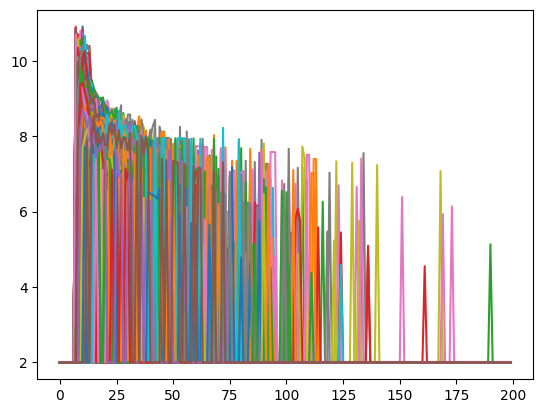

In [173]:
for n in range(x_train.shape[0]):
    plt.plot(x_train[n,1:])
plt.show()


In [174]:
# num_classes = y_train.shape[1]
########################################
# input_shape = (1,5,1)
# x = np.arange(np.prod(input_shape)).reshape(input_shape)      # test cropping#
# print(x)
# y = keras.layers.Cropping1D(cropping=(0,4))(x)
# z = keras.layers.Cropping1D(cropping=(1,0))(x)
# print(y)
# print(z)

In [314]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    d_1 = keras.layers.Cropping1D(cropping=(0,200))(input_layer)
    sig = keras.layers.Cropping1D(cropping=(1,0))(input_layer)
    
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(sig)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    #d_1 = keras.layers.BatchNormalization()(d_1)
    d_1 = keras.layers.Dense(16, activation='relu')(d_1)
    # d_1 = keras.layers.Dense(10, activation='relu')(d_1)
    d_1 = keras.layers.Reshape((16,))(d_1)
    
    d_1 = keras.layers.BatchNormalization()(d_1)
    gap = keras.layers.Dense(8, activation='relu')(gap)
    gap = keras.layers.BatchNormalization()(gap)
    
    merged = keras.layers.Concatenate()([d_1, gap])
    merged = keras.layers.Dense(8, activation='relu')(merged)
    
    output_layer = keras.layers.Dense(2, activation="linear")(merged)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [315]:
epochs = 1000
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="mean_absolute_error",
    metrics=["MeanAbsoluteError"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
12/12 [==============================] - 2s 47ms/step - loss: 0.4723 - mean_absolute_error: 0.4723 - val_loss: 0.4119 - val_mean_absolute_error: 0.4119
Epoch 2/1000
12/12 [==============================] - 0s 22ms/step - loss: 0.3641 - mean_absolute_error: 0.3641 - val_loss: 0.3185 - val_mean_absolute_error: 0.3185
Epoch 3/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.3162 - mean_absolute_error: 0.3162 - val_loss: 0.2610 - val_mean_absolute_error: 0.2610
Epoch 4/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.2852 - mean_absolute_error: 0.2852 - val_loss: 0.2366 - val_mean_absolute_error: 0.2366
Epoch 5/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.2519 - mean_absolute_error: 0.2519 - val_loss: 0.2316 - val_mean_absolute_error: 0.2316
Epoch 6/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.2141 - mean_absolute_error: 0.2141 - val_loss: 0.2300 - val_mean_absolute_error: 0.2300
Epoch 7/10

In [316]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

6/6 [==============================] - 0s 7ms/step - loss: 0.0820 - mean_absolute_error: 0.0820
Test accuracy 0.08204921334981918
Test loss 0.08204921334981918


In [317]:
x_test[0].shape

(201, 1)

In [334]:
i = 89
miu = model.predict(x_test[i:i+1])

mua = miu[0,0]
mus = miu[0,1]
d = x_test[i,0,0]

In [335]:
print(mua,mus,d)
print(an2[i,1],an2[i,2],an2[i,0])

0.40432006 0.31888798 0.005119709
0.06993596 0.17388496 0.005119709


In [324]:
def transmittance(d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
def error_cal(x,d,time,h):
        miu_a = x[0]
        miu_s = x[1]
        g = 0.85
        # d = 0.38e-3
        k=1
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = time*1e-9
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] ):

            intensity1[i] = transmittance( d, time[i], c, g, miu_a, miu_s)
        
        y3 = np.convolve(intensity1, h)
        y2 = intensity1*k
        return y2,y3

In [325]:
optical_paramter = np.array([mua*1e2,mus*200e2])
time_index = np.linspace(0.01,2e-9,200)
h = np.zeros((200,))
h[0]=1
y2,y3 = error_cal(optical_paramter,d,time_index,h)

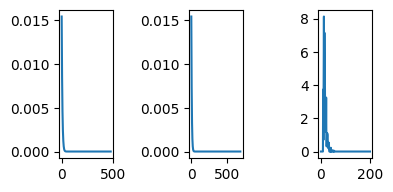

In [328]:
plt.figure(figsize = (4,2))
plt.subplot(1,3,1)
plt.plot(y2)
plt.subplot(1,3,2)
plt.plot(y3)
plt.subplot(1,3,3)
plt.plot(sig2[i,1:])
plt.tight_layout(pad=1.0)
plt.show()

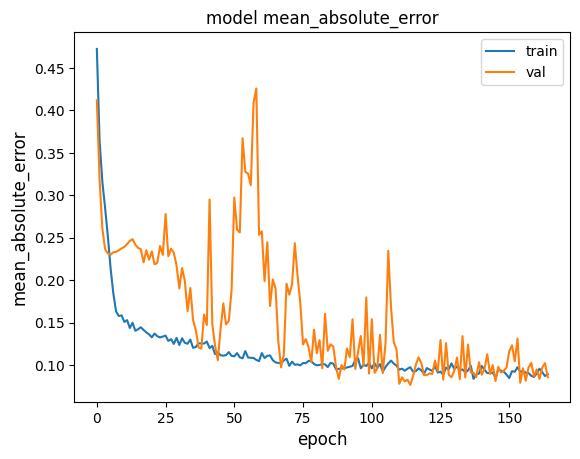

In [329]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# 你可以用pca或者一些降维方法把特征搞一下